In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [28]:
def make_triangle_se(side):
    h = int(round(np.sqrt(3)/2 * side))
    se = np.zeros((h, side), dtype=np.uint8)
    for r in range(h):
        span = int(round((side/2) * (1 - r/h)))
        left  = side//2 - span
        right = side//2 + span
        se[r, left:right+1] = 1
    return se

In [29]:
def dilation_binary(img, se, anchor):
    H, W = img.shape
    h, w = se.shape
    ax, ay = anchor
    out_H, out_W = H + h - 1, W + w - 1
    out = np.zeros((out_H, out_W), dtype=np.uint8)

    for i in range(out_H):
        for j in range(out_W):
            hit = False
            for u in range(h):
                for v in range(w):
                    if se[u, v] == 0:
                        continue
                    x = i - ax + u
                    y = j - ay + v
                    if 0 <= x < H and 0 <= y < W and img[x, y] == 1:
                        hit = True
                        break
                if hit:
                    break
            out[i, j] = 1 if hit else 0
    return out

In [30]:
import numpy as np

def erosion_binary(img: np.ndarray,
                   se: np.ndarray,
                   anchor: tuple[int,int]) -> np.ndarray:

    H, W = img.shape
    h, w = se.shape
    ax, ay = anchor

    # 1. 反射 SE 並計算新的錨點
    se_ref = np.flipud(np.fliplr(se))
    ax_ref = h - 1 - ax
    ay_ref = w - 1 - ay

    # 2. 對原圖做 zero‐padding，使得輸出可以對應到所有 (i,j)
    pad_top    = ax_ref
    pad_bottom = h - 1 - ax_ref
    pad_left   = ay_ref
    pad_right  = w - 1 - ay_ref
    img_pad = np.pad(img,
                     ((pad_top, pad_bottom),
                      (pad_left, pad_right)),
                     mode='constant',
                     constant_values=0)

    # 3. 初始化輸出
    out = np.zeros((H, W), dtype=np.uint8)

    # 4. 迴圈掃描每個輸出像素
    for i in range(H):
        for j in range(W):
            match = True

            for u in range(h):
                for v in range(w):
                    if se_ref[u, v] == 0:
                        continue
                    if img_pad[i + u, j + v] == 0:
                        match = False
                        break
                if not match:
                    break
            out[i, j] = 1 if match else 0

    return out


In [31]:
# 1. 建立 30 像素的正三角形 SE
side = 30
se = make_triangle_se(side)

# 2. 建立 200*200 的二值方形圖像，並在外部補 0
h, w = se.shape
pad_h, pad_w = h - 1, w - 1
original = np.ones((200, 200), dtype=np.uint8)
img = np.pad(
    original,
    pad_width=((pad_h, pad_h), (pad_w, pad_w)),
    mode='constant',
    constant_values=0
)

# 3. 計算 Anchor
anchor = (int(round(h / 3)), side // 2)

# 4. 執行膨脹
dilated = dilation_binary(img, se, anchor)

# 5. 執行侵蝕
eroded = erosion_binary(dilated, se, anchor)

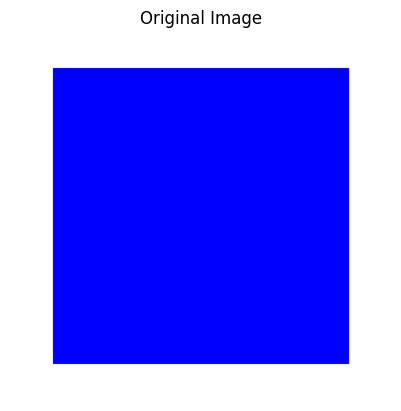

In [32]:
cmap = ListedColormap(['white', 'blue'])

plt.figure()
plt.imshow(img, cmap=cmap, vmin=0, vmax=1, aspect='equal', origin='upper')
plt.title('Original Image')
plt.axis('off')
plt.show()

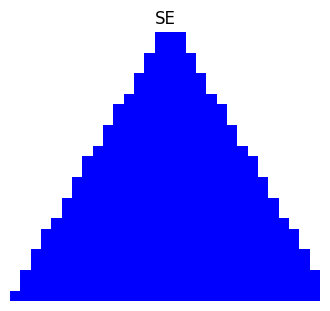

In [33]:
plt.figure(figsize=(4,4))
plt.imshow(se, cmap=cmap, origin='lower', aspect='equal')
plt.title(f'SE')
plt.axis('off')
plt.show()

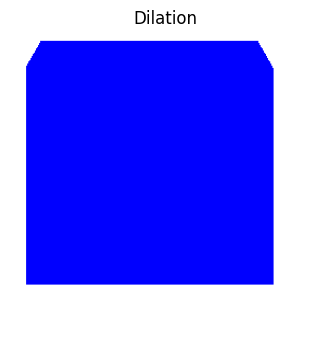

In [34]:
plt.figure(figsize=(4,4))
plt.imshow(dilated, cmap=cmap)
plt.axis('off')
plt.title('Dilation')
plt.show()

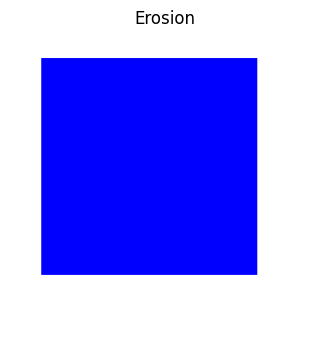

In [35]:
plt.figure(figsize=(4,4))
plt.imshow(eroded, cmap=cmap)
plt.axis('off')
plt.title('Erosion')
plt.show()